<a href="https://colab.research.google.com/github/glitch-y/CE888-Project/blob/main/2.%20Scripts/3.%20Offensive_Language_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions
!pip install emot
!pip install simpletransformers

# Import Modules
Import modules for preprocessing

In [ ]:
#Import modules
import html #import 'html' module to clean html elements such as '&amp;, &lt' etc.
import numpy as np
import pandas as pd
import contractions #import 'contractions' module to expand linguistic contactions (e.g. it's = it is)
from emot import UNICODE_EMO #import emoji dictionary to transform emojis into text
import re
import seaborn as sns
from sklearn.metrics import f1_score
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Import Data
Import data from TweetEval Github

In [ ]:
#Import files for the 'offensive' task
data_offensive_test = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_text.txt", 
                                delimiter='\t', dtype=str, header= None)
data_offensive_test_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_mapping = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/mapping.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_train = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_train_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_val = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_text.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_val_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)

#Assign column names for offensive datasets
data_offensive_test.columns =['content']
data_offensive_test_labels.columns =['labels']
data_offensive_mapping.columns =['labels','mapping']
data_offensive_train.columns =['content']
data_offensive_train_labels.columns =['labels']
data_offensive_val.columns =['content']
data_offensive_val_labels.columns =['labels'] 

# Preprocessing

##Replace misspelled words

Typos are common in text data and the scripts below create a dictionary of commonly mispelled words and applies it against the 3 'text' sets

In [ ]:
#Import misspelling data as dictionary
misspell_data = pd.read_csv("https://raw.githubusercontent.com/glitch-y/CE888-Project/main/1.%20Dictionaries/Misspelling.txt",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

#Preview misspelling dictionary
{v:miss_corr[v] for v in [list(miss_corr.keys())[k] for k in range(10)]}

{'Apenines': 'Apennines',
 'Appenines': 'Apennines',
 'Athenean': 'Athenian',
 'Atheneans': 'Athenians',
 'Bernouilli': 'Bernoulli',
 'Blitzkreig': 'Blitzkrieg',
 'Brasillian': 'Brazilian',
 'Britian': 'Britain',
 'Brittish': 'British',
 'Ceasar': 'Caesar'}

In [ ]:
#Create misspelling correction function
def misspelled_correction(x):
    for i in x.split(): 
        if i in miss_corr.keys(): 
            x = x.replace(i, miss_corr[i]) 
    return x

#Apply misspelling correction to text dataframes as new column
data_offensive_test['content_clean'] = data_offensive_test.content.apply(lambda x : misspelled_correction(x).lower())
data_offensive_train['content_clean'] = data_offensive_train.content.apply(lambda x : misspelled_correction(x).lower())
data_offensive_val['content_clean'] = data_offensive_val.content.apply(lambda x : misspelled_correction(x).lower())

##Replace abbreviated words

Social media users normally use abbreviated text due to the fast nature of writing a post as well as certain limitations in terms of characters (a well-known aspect of Twitter. 

The script below create a dictionary of commonly known internet abbreviations and applies it against the 3 'text' data sets.

In [ ]:
#Abbreviated chat words conversion
#Create Dictionary
chat_dictionary = pd.read_csv("https://raw.githubusercontent.com/glitch-y/CE888-Project/main/1.%20Dictionaries/SlangDictionary.csv",dtype=str, names=["Slang", "Translation"])
chat_dictionary=chat_dictionary.apply(lambda x: x.str.lower())
slang_corr = dict(zip(chat_dictionary.Slang, chat_dictionary.Translation))

#Preview abbreviation dictionary
{v:slang_corr[v] for v in [list(slang_corr.keys())[k] for k in range(10)]}

{'a.s.a.p.': 'as soon as possible',
 'af': 'as fuck',
 'ama': 'ask me anything',
 'asap': 'as soon as possible',
 'atm': 'at the moment',
 'bbl': 'be back later',
 'bbs': 'be back soon',
 'bcs': 'because',
 'bcus': 'because',
 'bcuz': 'because'}

In [ ]:
#Create abbreviation replacement function
def abbrev_replace(x):
    for i in x.split(): 
        if i in slang_corr.keys(): 
            x = x.replace(i, slang_corr[i]) 
    return x

#Apply misspelling correction to dataframe as new column
data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x : abbrev_replace(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x : abbrev_replace(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x : abbrev_replace(x))

#Check
data_offensive_train.head()

,content,content_clean
0,@user Bono... who cares. Soon people will unde...,@user bono... who cares. soon people will unde...
1,@user Eight years the republicans denied obama...,@user eight years the republicans denied obama...
2,@user Get him some line help. He is gonna be j...,@user get him some line help. he is gonna be j...
3,@user @user She is great. Hi Fiona!,@user @user she is great. hi fiona!
4,@user She has become a parody unto herself? Sh...,@user she has become a parody unto herself? sh...


##Remove HTML elements

Data scraped from various websites usually returns certain html elements such as '&amp;' for '&'

The script below uses the 'html' module to clean the data of any such occurences

In [ ]:
#clean HTML charachters such as &amp;, &lt; etc using 'html' module
data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: html.unescape(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: html.unescape(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: html.unescape(x))

##Fix language contractions

The script below uses the 'contractions' module to expand any language contractions such as 'let's' into 'let us' or 'it's' into 'it is'

In [ ]:
#fix contractions; i.e. 'It's' transforms into 'it is'
data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: contractions.fix(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: contractions.fix(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: contractions.fix(x))

##Remove 'newlines' and replace '&' with 'and'


In [ ]:
#Remove newlines from data and replace '&' with 'and'
data_offensive_test.content_clean = data_offensive_test.content_clean.replace(r'\\n',' ', regex=True)
data_offensive_test.content_clean = data_offensive_test.content_clean.replace(r'&','and', regex=True)

data_offensive_train.content_clean = data_offensive_train.content_clean.replace(r'\\n',' ', regex=True)
data_offensive_train.content_clean = data_offensive_train.content_clean.replace(r'&','and', regex=True)

data_offensive_val.content_clean = data_offensive_val.content_clean.replace(r'\\n',' ', regex=True)
data_offensive_val.content_clean = data_offensive_val.content_clean.replace(r'&','and', regex=True)

##Convert emojis into text

Emoji's describe a variety of offensives or objects which can help increase the accuracy of the algorithm. 

The script below uses the 'emot' module to lookup emoji's in the module dictionary and translate them into text.


In [ ]:
#convert emojis into text
def convert_emojis(x):
    for emot in UNICODE_EMO:
        x = x.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return x

data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: convert_emojis(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: convert_emojis(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: convert_emojis(x))

##Remove unnecessary punctuation

Certain types of punctuation is not of particular use and is removed using the script below. 

However, exclamation and question marks apostrophes have not been taken out as they help set the tone or define the relationships between words.


In [ ]:
#Remove unnecessary punctuation
def punctuation(x): 
  
    punctuations = '()-[]{};:\<>/#$%^&_~,.'
  
    for i in x.lower(): 
        if i in punctuations: 
            x = x.replace(i, " ") 
    return x

data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: punctuation(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: punctuation(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: punctuation(x))

In [ ]:
#Change Exclamation Marks
def question(x): 
  
    punctuations = '?'
  
    for i in x.lower(): 
        if i in punctuations: 
            x = x.replace(i, " question ") 
    return x

data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: question(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: question(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: question(x))

In [ ]:
#Change Exclamation Marks
def exclamation(x): 
  
    punctuations = '?'
  
    for i in x.lower(): 
        if i in punctuations: 
            x = x.replace(i, " exclamation ") 
    return x

data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: question(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: question(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: question(x))

##Remove '@user' mentions


In [ ]:
#Remove @user mentions
data_offensive_test.content_clean = data_offensive_test.content_clean.str.replace('@user','')
data_offensive_train.content_clean = data_offensive_train.content_clean.str.replace('@user','')
data_offensive_val.content_clean = data_offensive_val.content_clean.str.replace('@user','')


data_offensive_test.head()

,content,content_clean
0,#ibelieveblaseyford is liar she is fat ugly li...,ibelieveblaseyford is liar she is fat ugly li...
1,@user @user @user I got in a pretty deep debat...,i got in a pretty deep debate with my frien...
2,"...if you want more shootings and more death, ...",if you want more shootings and more death ...
3,Angels now have 6 runs. Five of them have come...,angels now have 6 runs five of them have come...
4,#Travel #Movies and Unix #Fortune combined Vi...,travel movies and unix fortune combined vi...


##Assign labels to Tweet datasets

The script below assigns the labels to the 3 separate 'text' files.

In [ ]:
#Test Data
data_offensive_test.reset_index(inplace=True)
data_offensive_test_labels.reset_index(inplace=True)
processed_offensive_test=data_offensive_test.merge(data_offensive_test_labels)

#Train Data
data_offensive_train.reset_index(inplace=True)
data_offensive_train_labels.reset_index(inplace=True)
processed_offensive_train=data_offensive_train.merge(data_offensive_train_labels)

#Val Data
data_offensive_val.reset_index(inplace=True)
data_offensive_val_labels.reset_index(inplace=True)
processed_offensive_val=data_offensive_val.merge(data_offensive_val_labels)

##Map labels
Map each row with the respective offensive tags, based on the values in column 'Labels'


In [ ]:
#offensive test data mapping
mapped_offensive_test=processed_offensive_test[['content_clean','labels']].merge(data_offensive_mapping,how='left')
mapped_offensive_test['labels'] = pd.to_numeric(mapped_offensive_test['labels'])
#Check
print(mapped_offensive_test)

                                         content_clean  labels        mapping
0     ibelieveblaseyford is liar she is fat ugly li...       1      offensive
1       i got in a pretty deep debate with my frien...       0  not-offensive
2       if you want more shootings and more death  ...       0  not-offensive
3    angels now have 6 runs  five of them have come...       0  not-offensive
4     travel  movies and unix  fortune combined  vi...       0  not-offensive
..                                                 ...     ...            ...
855   cnn irrationally argues 4 legalising  abortio...       0  not-offensive
856                city of chicago  democrat run wi...       0  not-offensive
857   conservatives do not care what you post  it i...       1      offensive
858   antifa  resist   trump is trying to bring wor...       0  not-offensive
859   maine you need to face facts  does not really...       0  not-offensive

[860 rows x 3 columns]


In [ ]:
#offensive train data mapping
mapped_offensive_train=processed_offensive_train[['content_clean','labels']].merge(data_offensive_mapping,how='left')
mapped_offensive_train['labels'] = pd.to_numeric(mapped_offensive_train['labels'])
#Check
print(mapped_offensive_train)

                                           content_clean  labels        mapping
0       bono    who cares  soon people will understan...       0  not-offensive
1       eight years the republicans denied obama’s pi...       1      offensive
2       get him some line help  he is going to be jus...       0  not-offensive
3                               she is great  hi fiona!        0  not-offensive
4       she has become a parody unto herself question...       1      offensive
...                                                  ...     ...            ...
11911   i wonder if they are sex traffic victims ques...       1      offensive
11912   do we dare say he is    better than nyjer que...       0  not-offensive
11913                          no idea who he is  sorry        0  not-offensive
11914   professor who shot self over trump says gun c...       0  not-offensive
11915     here your proof!  our african 🇺🇸 friends do...       1      offensive

[11916 rows x 3 columns]


In [ ]:
#offensive val data mapping
mapped_offensive_val=processed_offensive_val[['content_clean','labels']].merge(data_offensive_mapping,how='left')
mapped_offensive_val['labels'] = pd.to_numeric(mapped_offensive_val['labels'])
#Check
print(mapped_offensive_val)

                                          content_clean  labels        mapping
0                     wiiu is not even a real console         0  not-offensive
1        if he is from az i would put my money on se...       1      offensive
2      i thought canada had strict gun control   hel...       0  not-offensive
3                     following all  maga patriots p...       0  not-offensive
4                  1 minute of truth  gun control via         0  not-offensive
...                                                 ...     ...            ...
1319    whose twitter interest start with food  is h...       0  not-offensive
1320    how did the press"" get the letter question ...       0  not-offensive
1321        sorry about your son  i am sure he would...       0  not-offensive
1322                              fuck alan I am sorry        1      offensive
1323   tories  labour  ge2017  conservatives conserv...       0  not-offensive

[1324 rows x 3 columns]


#Data Exploration

not-offensive    620
offensive        240
Name: mapping, dtype: int64


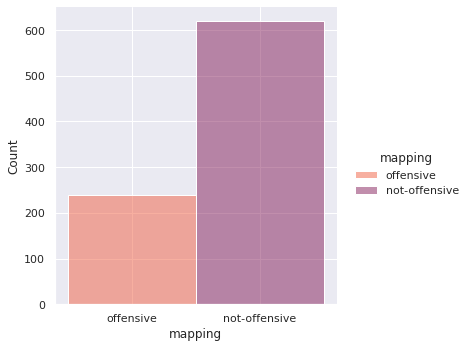

In [ ]:
#Exploration of 'offensive Test Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_offensive_test, x='mapping', hue='mapping',palette='rocket_r')
print(mapped_offensive_test.mapping.value_counts())

not-offensive    7975
offensive        3941
Name: mapping, dtype: int64


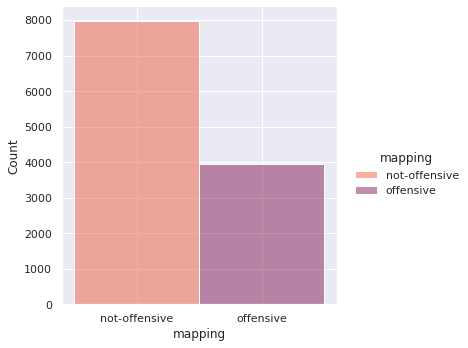

In [ ]:
#Exploration of 'offensive Train Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_offensive_train, x='mapping', hue='mapping', palette='rocket_r')
print(mapped_offensive_train.mapping.value_counts())

not-offensive    865
offensive        459
Name: mapping, dtype: int64


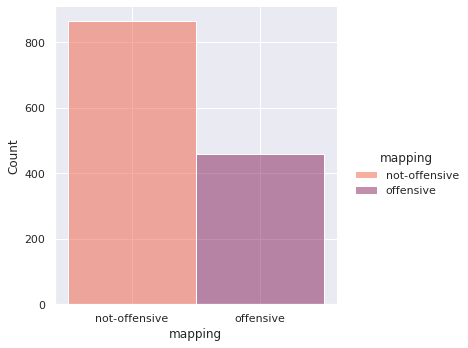

In [ ]:
#Exploration of 'offensive Val Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_offensive_val, x='mapping', hue='mapping', palette='rocket_r')
print(mapped_offensive_val.mapping.value_counts())

#Model Setup and Scoring

##Roberta Model Setup, Training and Evaluation

In [ ]:
model_args = ClassificationArgs(num_train_epochs=4, overwrite_output_dir=True, manual_seed=123, train_batch_size = 128, learning_rate = 1e-5, eval_batch_size = 8, adam_epsilon=2e-8)
roberta = ClassificationModel(model_type='roberta', model_name='roberta-base', use_cuda=True, num_labels=2, args=model_args)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
roberta.train_model(mapped_offensive_train)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/11916 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/94 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/94 [00:00<?, ?it/s]

(376, 0.4449762820484156)

In [ ]:
result, model_outputs, wrong_predictions = roberta.eval_model(mapped_offensive_test)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/860 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
predictions = []
for x in model_outputs:
  predictions.append(np.argmax(x))
print("f1 score RoBERTa Base:", f1_score(mapped_offensive_test["labels"], predictions, average='macro'))

f1 score RoBERTa Base: 0.803892800387477


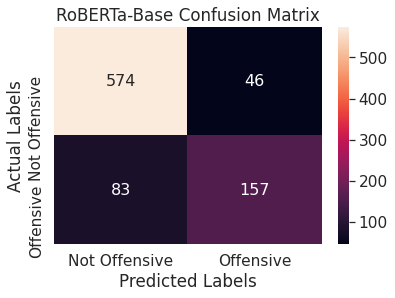

In [ ]:
classlabels = ['Not Offensive', 'Offensive']
cm = confusion_matrix(mapped_offensive_test['labels'], predictions)
dfcm = pd.DataFrame(cm, classlabels, classlabels)
sns.set(font_scale=1.4) # for label size
sns.heatmap(dfcm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"RoBERTa-Base Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

##XLNet Model Setup, Training and Evaluation

In [ ]:
model_args = ClassificationArgs(num_train_epochs=4, overwrite_output_dir=True, manual_seed=123, 
                                eval_batch_size = 16 ,train_batch_size = 64, learning_rate = 1e-5, adam_epsilon = 2e-8)
xlnet = ClassificationModel(model_type='xlnet', model_name='xlnet-base-cased', use_cuda=True, num_labels=2, args=model_args)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [ ]:
xlnet.train_model(mapped_offensive_train)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/11916 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/187 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 4:   0%|          | 0/187 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/187 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/187 [00:00<?, ?it/s]

(748, 0.4691789322557615)

In [ ]:
result, model_outputs, wrong_predictions = xlnet.eval_model(mapped_offensive_test)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/860 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
predictions = []
for x in model_outputs:
  predictions.append(np.argmax(x))
print("f1 score for XLNet:", f1_score(mapped_offensive_test["labels"], predictions, average='macro'))

f1 score for XLNet: 0.8140649022622447


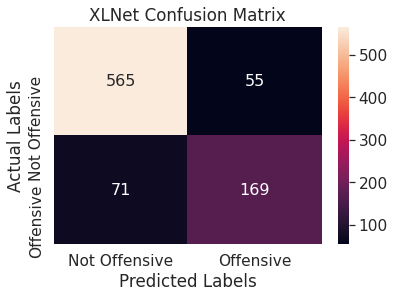

In [ ]:
classlabels = ['Not Offensive', 'Offensive']
cm = confusion_matrix(mapped_offensive_test['labels'], predictions)
dfcm = pd.DataFrame(cm, classlabels, classlabels)
sns.set(font_scale=1.4) # for label size
sns.heatmap(dfcm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"XLNet Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()